<a href="https://colab.research.google.com/github/Lnchi/CIP-Data-Science-Internship/blob/main/EmailSpamDetectionUsingPython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project name : Email Spam Detection using Python.

Detecting email spam is a prevalent application of natural language processing (NLP), In this task, we classify whether an email is spam or not using machine learning algorithms.






# Import Libraries

In [1]:
#panda : to read and process the email data 
import pandas as pd 
#sklearn : to build the machine learning model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Load the dataset

 The dataset that we will utilize is the Spam Mails Dataset available on Kaggle, which comprises a collection of emails that have been pre-labeled as either spam or not spam.



In [2]:
!pip install kaggle #Install the Kaggle library.
!mkdir ~/.kaggle #Create a new directory named ".kaggle".
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json #copy the “kaggle.json” file from the mounted google drive to the current instance storage. 
!chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download venky73/spam-mails-dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  0% 0.00/1.86M [00:00<?, ?B/s]
100% 1.86M/1.86M [00:00<00:00, 41.6MB/s]


In [3]:
!unzip spam-mails-dataset.zip

Archive:  spam-mails-dataset.zip
  inflating: spam_ham_dataset.csv    


In [4]:
df = pd.read_csv("spam_ham_dataset.csv")
df.sample(10)

,Unnamed: 0,label,text,label_num
1127,4354,spam,Subject: don ' t be fooled abazis\r\nabazis\r\...,1
1291,2867,ham,Subject: natural gas nomination for 04 / 01\r\...,0
4707,1798,ham,Subject: union carbide - seadrift\r\ndaren\r\n...,0
454,2617,ham,Subject: re : meter 6884\r\ni may need more as...,0
2354,4263,spam,Subject: legal operating systems for a third o...,1
1420,3297,ham,"Subject: hpl nom for may 30 , 2001\r\n( see at...",0
2519,197,ham,Subject: the 1999 form w - 2 and retiree tax f...,0
535,2293,ham,"Subject: hpl nom . for dec . 28 , 2000\r\n( se...",0
356,2624,ham,Subject: enron / hpl nom for february 24 - 26 ...,0
4523,975,ham,Subject: re : wholesale volumes\r\ntexas has a...,0


In [5]:
df=df.drop(['Unnamed: 0'],axis=1) #drop Unnamed: 0 column  
df.sample(10)

,label,text,label_num
875,spam,"Subject: account # 20367 s tue , 28 jun 2005 1...",1
4248,ham,Subject: neon discussion november 8\r\nhere ar...,0
1602,ham,Subject: re : pennzoil avails\r\n- - - - - - -...,0
2446,spam,Subject: re : this is how i made that money wi...,1
3279,ham,Subject: fyi - union carbide\r\nunion carbide ...,0
1138,ham,Subject: valero plants\r\nhey buddy ! ! how ' ...,0
1713,ham,"Subject: shipper meter list\r\nsorry , i attac...",0
1887,ham,"Subject: re : meter 1550\r\nper gas control , ...",0
4097,spam,Subject: re : walium clalls vi - agra\r\nre : ...,1
2159,spam,"Subject: get xanax , darvocet over night - no ...",1


- The dataset consists of three variables: "label," which indicates whether an email is classified as "Spam" or "Ham"; "text," which contains the email content; and "label_num," which is assigned a value of 1 if the email is spam, and 0 if it is not.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      5171 non-null   object
 1   text       5171 non-null   object
 2   label_num  5171 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 121.3+ KB


In [7]:
df['label'].value_counts()

ham     3672
spam    1499
Name: label, dtype: int64

In [8]:
label = df.groupby(by = ["label_num"]).size().reset_index(name="Count")
figure = px.bar(label,x='label_num',y='Count', color='label_num', title='The count of spam labels.')
figure.show()

- The dataset we are utilizing is imbalanced, as the number of samples labeled as 'Ham' is significantly higher than those labeled as 'Spam'.

# Preprocess the data
- Preprocessing of the data is required before constructing the machine learning model.

- Check the data for any missing values and clean the data

In [9]:
df.isna().sum()

label        0
text         0
label_num    0
dtype: int64

In [10]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
5166    False
5167    False
5168     True
5169    False
5170    False
Length: 5171, dtype: bool

In [11]:
df.drop_duplicates(inplace=True)

- Text preprocessing by removing stop words and non-alphanumeric characters from the email text data.

In [12]:
# list of stop words, which are common words that don't add much meaning to a text.
# These words will be removed from the text data during preprocessing.
SW=['a', 'an', 'the', 'in', 'of', 'at', 'on', 'by', 'I', 'you', 'he', 'she', 'it', 'we', 'they']

# Apply a lambda function to the 'text' column using the apply() method. 
# The lambda function takes each email text, splits it into words,
# removes any stop words, converts the remaining words to lowercase, and joins them back into a string.
df['text']=df['text'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word.lower() not in SW]))

# Apply another lambda function to the 'text' column using the str.replace() method. 
# This function removes any non-alphanumeric characters from the text data.
# [^\w\s] is a regular expression pattern that matches any character that is not a word character 
# (\w, which includes all letters, digits, and underscores) or whitespace (\s). 
# The ^ symbol inside the square brackets negates the pattern, so it matches any character that is not a word character or whitespace.
df['text']=df['text'].str.replace('[^\w\s]','')
df.sample(10)

<ipython-input-12-260715a1b0e3>:15: FutureWarning:

The default value of regex will change from True to False in a future version.



,label,text,label_num
739,ham,subject phillips petroleum inc ...,0
2683,spam,subject survivor junction genuine college degr...,1
2652,spam,subject how to acquire and use international d...,1
1249,ham,subject enron keep up good work home love...,0
4083,spam,subject need this abazis look this fers vi ...,1
2584,ham,subject panenergy 4 01 daren did exchange wi...,0
360,ham,subject hpl nom for january 13 2001 see atta...,0
2376,ham,subject hpl nom for february 27 2001 see att...,0
1362,ham,subject http www pge texas com www gtt...,0
1414,ham,subject intraday eastrans nomination change fo...,0


 - We will divide the data into two parts: a training set and a testing set.

In [13]:
# Split the data into training and testing sets
# Sets the testing set to 20 percent of df['text'] and df['label'].
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=70)

- We will employ the CountVectorizer class to transform the textual data into a matrix of term frequencies (of token counts).



In [14]:
# Create a Vectorizer Object
Counvect=CountVectorizer()
# Fit the CountVectorizer to data
# CountVectorizer() assigns a numerical value to each word in the dataset and computes the frequency of occurrence
# of each word. The resulting values are stored in the variable "Counvect"
train_features=Counvect.fit_transform(x_train)
test_features=Counvect.transform(x_test)
print(train_features)

  (0, 39136)	1
  (0, 42275)	2
  (0, 43726)	1
  (0, 7647)	1
  (0, 19288)	1
  (0, 24670)	2
  (0, 40492)	1
  (0, 28586)	1
  (0, 399)	1
  (0, 29110)	1
  (0, 4326)	1
  (0, 32413)	1
  (0, 15022)	1
  (0, 6001)	2
  (0, 34061)	2
  (0, 30716)	1
  (0, 23896)	1
  (0, 40765)	1
  (0, 40373)	1
  (0, 31691)	1
  (0, 7338)	1
  (0, 38911)	1
  (0, 19938)	1
  (0, 20554)	1
  (0, 40226)	1
  :	:
  (3993, 42030)	1
  (3993, 31161)	1
  (3993, 22259)	1
  (3993, 30879)	1
  (3993, 44242)	1
  (3993, 21567)	1
  (3993, 11207)	1
  (3993, 30555)	1
  (3993, 25046)	1
  (3993, 42339)	1
  (3993, 8049)	1
  (3993, 1504)	1
  (3993, 3007)	1
  (3993, 27745)	1
  (3993, 8367)	1
  (3993, 39709)	1
  (3993, 32654)	1
  (3993, 43947)	1
  (3993, 1194)	1
  (3993, 22962)	1
  (3993, 23445)	1
  (3993, 37272)	1
  (3993, 15426)	1
  (3993, 44535)	1
  (3993, 43013)	1


- (0, 37791)	1 : The index of the email is denoted by 0. The middle column in the output represents the sequence number assigned to each word by the CountVectorizer function, and the values on the right indicate the frequency count of each word.

# Train the Model

 Now that the data has been preprocessed, we can proceed with training our machine learning model. For this purpose, we will be using Scikit-learn's MultinomialNB, svm and linear_model classes to build a Naive Bayes, an SVM and a Logistic Regression model.

- A **Naive Bayes** model is a type of machine learning model based on the Bayesian classification method. It is commonly used for text classification in natural language processing and can be trained to predict the category or label of a document based on its textual content

In [15]:
model_NB= MultinomialNB() # create model 
model_NB.fit(train_features, y_train) # train model

MultinomialNB()

- **SVM**, short for support vector machine, is a classification and regression algorithm that uses a linear model. The basic idea behind SVM is to create a line or a hyperplane that can separate the data into different classes. One of the benefits of SVM is that it can handle both linear and non-linear problems

In [16]:
model_SVM= svm.SVC()
model_SVM.fit(train_features, y_train)

SVC()

- **Logistic Regression** is a popular machine learning algorithm used for binary classification problems. In Logistic Regression, a linear model is used to predict the probability of the positive class (i.e., class 1), given a set of input features. The model then uses a logistic function (i.e., the sigmoid function) to convert this probability value into a binary output prediction.

In the context of spam detection, Logistic Regression can be used to predict whether an email is spam or not based on various features of the email. The model can be trained on a dataset of pre-labeled emails and then used to make predictions on new, unseen emails.

In [17]:
model_LR= LogisticRegression()
model_LR.fit(train_features, y_train)

LogisticRegression()

- Trains the model using the training data x_train_features and corresponding labels y_train. The "fit" method adjusts the model weights to the training data to minimize the prediction error. Once the model is trained, it can be used to predict class labels for new data.

# Test the performance of the model on the test set.
- Calculates the accuracy of the machine learning model by comparing the predicted target variable (spam or non-spam) with the actual target variable (y_test) on the test dataset (x_test_features). The resulting accuracy value is then assigned to the variable "accuracy".


In [18]:
# Naive Bayes model
y_pred_NB=model_NB.predict(test_features) #y_pred: predicted labels
y_pred_NB

array(['ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham',
       'ham', 'ham', 'ham', 'ham', 'spam', 'spam', 'spam', 'ham', 'ham',
       'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'ham', 'spam',
       'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham',
       'ham', 'spam', 'ham', 'ham', 'ham', 'spam', 'spam', 'ham', 'ham',
       'ham', 'ham', 'ham', 'ham', 'spam', 'ham', 'spam', 'ham', 'spam',
       'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'spam', 'ham',
       'ham', 'spam', 'ham', 'spam', 'ham', 'ham', 'ham', 'spam', 'ham',
       'ham', 'spam', 'ham', 'spam', 'spam', 'ham', 'ham', 'spam', 'ham',
       'spam', 'spam', 'spam', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham',
       'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam',
       'ham', 'ham', 'ham', 'spam', 'spam', 'spam', 'ham', 'spam', 'spam',
       'spam', 'spam', 'spam', 'ham', 'ham', 'spam', 'spam', 'spam',
       'ham', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham',

In [19]:
# SVM model
y_pred_SVM=model_SVM.predict(test_features)
y_pred_SVM

array(['ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham',
       'ham', 'ham', 'ham', 'spam', 'spam', 'spam', 'spam', 'ham', 'ham',
       'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'ham', 'spam',
       'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham',
       'spam', 'spam', 'ham', 'ham', 'ham', 'spam', 'spam', 'ham', 'ham',
       'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'ham', 'spam',
       'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'spam', 'ham',
       'ham', 'spam', 'ham', 'spam', 'ham', 'ham', 'ham', 'spam', 'ham',
       'ham', 'spam', 'ham', 'spam', 'ham', 'ham', 'ham', 'spam', 'ham',
       'spam', 'spam', 'spam', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham',
       'ham', 'spam', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham', 'spam',
       'ham', 'ham', 'ham', 'spam', 'spam', 'spam', 'ham', 'spam', 'spam',
       'spam', 'spam', 'spam', 'ham', 'ham', 'spam', 'spam', 'spam',
       'ham', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham

In [20]:
#LogisticRegression
y_pred_LR=model_LR.predict(test_features)
y_pred_LR

array(['ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham',
       'ham', 'ham', 'ham', 'ham', 'spam', 'spam', 'spam', 'ham', 'ham',
       'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'ham', 'spam',
       'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham',
       'ham', 'spam', 'ham', 'ham', 'ham', 'spam', 'spam', 'ham', 'ham',
       'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'ham', 'spam',
       'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'spam', 'ham',
       'ham', 'spam', 'ham', 'spam', 'ham', 'ham', 'ham', 'spam', 'ham',
       'ham', 'spam', 'ham', 'spam', 'ham', 'ham', 'ham', 'spam', 'ham',
       'spam', 'spam', 'spam', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham',
       'ham', 'spam', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'spam',
       'ham', 'ham', 'ham', 'spam', 'spam', 'spam', 'ham', 'spam', 'spam',
       'spam', 'spam', 'spam', 'ham', 'ham', 'spam', 'spam', 'spam',
       'ham', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham', 

In [21]:
# Naive Bayes model
Accuracy=accuracy_score(y_pred_NB,y_test) #y_test: true labels 
print(Accuracy)

0.987987987987988


In [22]:
# SVM model
Accuracy=accuracy_score(y_pred_SVM,y_test) 
print(Accuracy)

0.964964964964965


In [23]:
#Logistic Regression model
Accuracy=accuracy_score(y_pred_LR,y_test) 
print(Accuracy)

0.978978978978979


- classification_report takes in the true labels and predicted labels as input and generates a report with precision, recall, F1-score, and support for each class.

In [24]:
#A report with precision, recall, F1-score, and support for each class.

# Naive Bayes model
report=classification_report(y_test,y_pred_NB)
print(report)

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       706
        spam       0.98      0.98      0.98       293

    accuracy                           0.99       999
   macro avg       0.99      0.98      0.99       999
weighted avg       0.99      0.99      0.99       999



In [25]:
# SVM model
report=classification_report(y_test,y_pred_SVM)
print(report)

              precision    recall  f1-score   support

         ham       0.99      0.96      0.97       706
        spam       0.92      0.97      0.94       293

    accuracy                           0.96       999
   macro avg       0.95      0.97      0.96       999
weighted avg       0.97      0.96      0.97       999



In [26]:
#Logistic Regression model
report=classification_report(y_test,y_pred_LR)
print(report)

              precision    recall  f1-score   support

         ham       0.99      0.98      0.99       706
        spam       0.95      0.98      0.96       293

    accuracy                           0.98       999
   macro avg       0.97      0.98      0.97       999
weighted avg       0.98      0.98      0.98       999



- Creates a confusion matrix based on the true labels y_test and predicted labels y_pred. A confusion matrix is a table that shows the number of true positive, true negative, false positive, and false negative predictions made by a classification model. It can be used to evaluate the performance of a machine learning model.

Text(50.722222222222214, 0.5, 'Actual')

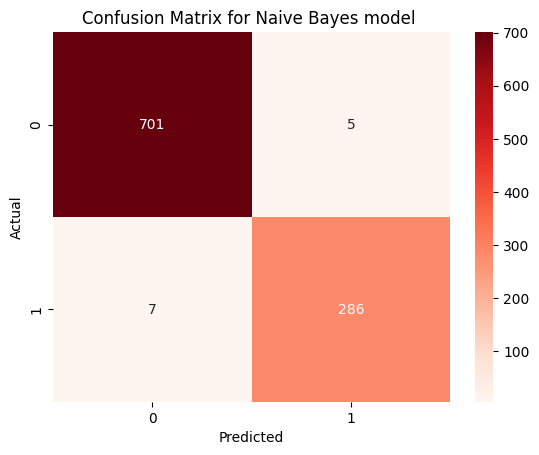

In [27]:
# Naive Bayes model

# assuming y_pred_NB and y_test are the predicted and true labels respectively
cm = confusion_matrix(y_test, y_pred_NB)
plt.title('Confusion Matrix for Naive Bayes model ')
# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Reds', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(50.722222222222214, 0.5, 'Actual')

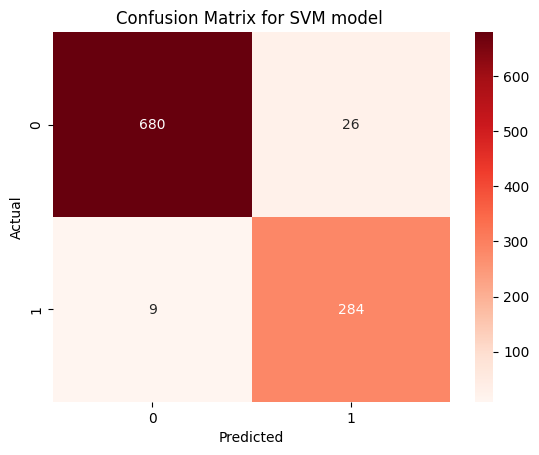

In [28]:
# SVM

# assuming y_pred_SVM and y_test are the predicted and true labels respectively
cm = confusion_matrix(y_test, y_pred_SVM)
plt.title('Confusion Matrix for SVM model ')
# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Reds', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(50.722222222222214, 0.5, 'Actual')

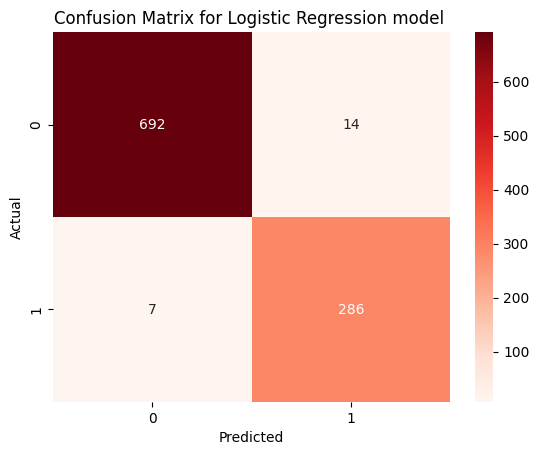

In [29]:
# Logistic Regression model

# assuming y_pred_LR and y_test are the predicted and true labels respectively
cm = confusion_matrix(y_test, y_pred_LR)
plt.title('Confusion Matrix for Logistic Regression model ')
# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Reds', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')